# Tensorflow SOM with multi_conv_rnn

In [1]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt
from scipy import signal


from mpl_toolkits.mplot3d import Axes3D
import somoclu
from sklearn.metrics.pairwise import pairwise_distances
# import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle
import neural_map as nm
import utils

from Speech_command_classification.convRNN import MultiConvRNN
from Speech_command_classification.audio_processing import AudioProcessor
from Speech_command_classification import utils as rnn_utils

np.set_printoptions(precision=3)

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Load multi_conv_rnn

In [2]:
name = 'multi_conv_rnn_4'
meta_path = r'C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000.meta'
ckpnt_path = r'C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000'

sess = tf.Session()
with sess.as_default():
    rnn = MultiConvRNN.restore(name, meta_path, ckpnt_path)

INFO:tensorflow:Restoring parameters from C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000


## 2 - Create data generator

In [3]:
with sess.as_default():
    # import model settings
    model_settings = rnn_utils.get_default_model_settings()
    data_dir = model_settings['data_dir']
    wanted_words = model_settings['wanted_words']
    validation_percentage = model_settings['validation_percentage']
    testing_percentage = model_settings['testing_percentage']
    model_settings['strip_window_size_ms'] = 30.0
    model_settings['strip_window_stride_ms'] = 10.0
    model_settings['window_size_ms'] = 30.0
    model_settings['window_stride_ms'] = 10.0

    # init audio preprocessing object
    proc = AudioProcessor(model_settings,
                          data_dir,
                          wanted_words=wanted_words.split(','),
                          validation_percentage=validation_percentage,
                          testing_percentage=testing_percentage)

## 3 - Generate data for the RNN

In [4]:
print("generating mfcc samples")
num_train_samples = 300
num_test_samples = 100
index_to_word = {v:k for k,v in proc.word_to_index.items()}
with sess.as_default():
    rnn_train_x, train_y_index = proc.get_data(num_train_samples, 0, 'training')
    rnn_test_x, test_y_index = proc.get_data(num_test_samples, 0, 'testing')
train_y = [index_to_word[i] for i in train_y_index]
test_y = [index_to_word[i] for i in test_y_index]
print(rnn_train_x.shape)

generating mfcc samples
(300, 95, 3, 40)


## 4 - Feed data to the RNN

In [5]:
batch_size = 100
train_idxs = range(0, num_train_samples,  batch_size)
test_idxs = range(0, num_test_samples,  batch_size)
with sess.as_default():
    train_x = [rnn.get_hidden_state(rnn_train_x[i: i + batch_size])[0][0] for i in train_idxs]
    train_x = np.reshape(train_x, (num_train_samples, -1))

    test_x = [rnn.get_hidden_state(rnn_test_x[i: i + batch_size])[0][0] for i in test_idxs]
    test_x = np.reshape(test_x, (num_test_samples, -1))
    
    
print("train shape:", train_x.shape)
print(train_y[:10])

train shape: (300, 9500)
['off', 'off', 'marvin', 'down', 'marvin', 'right', 'on', 'five', 'four', 'down']


## 4.1 - Show avg of the hidden states within class

23


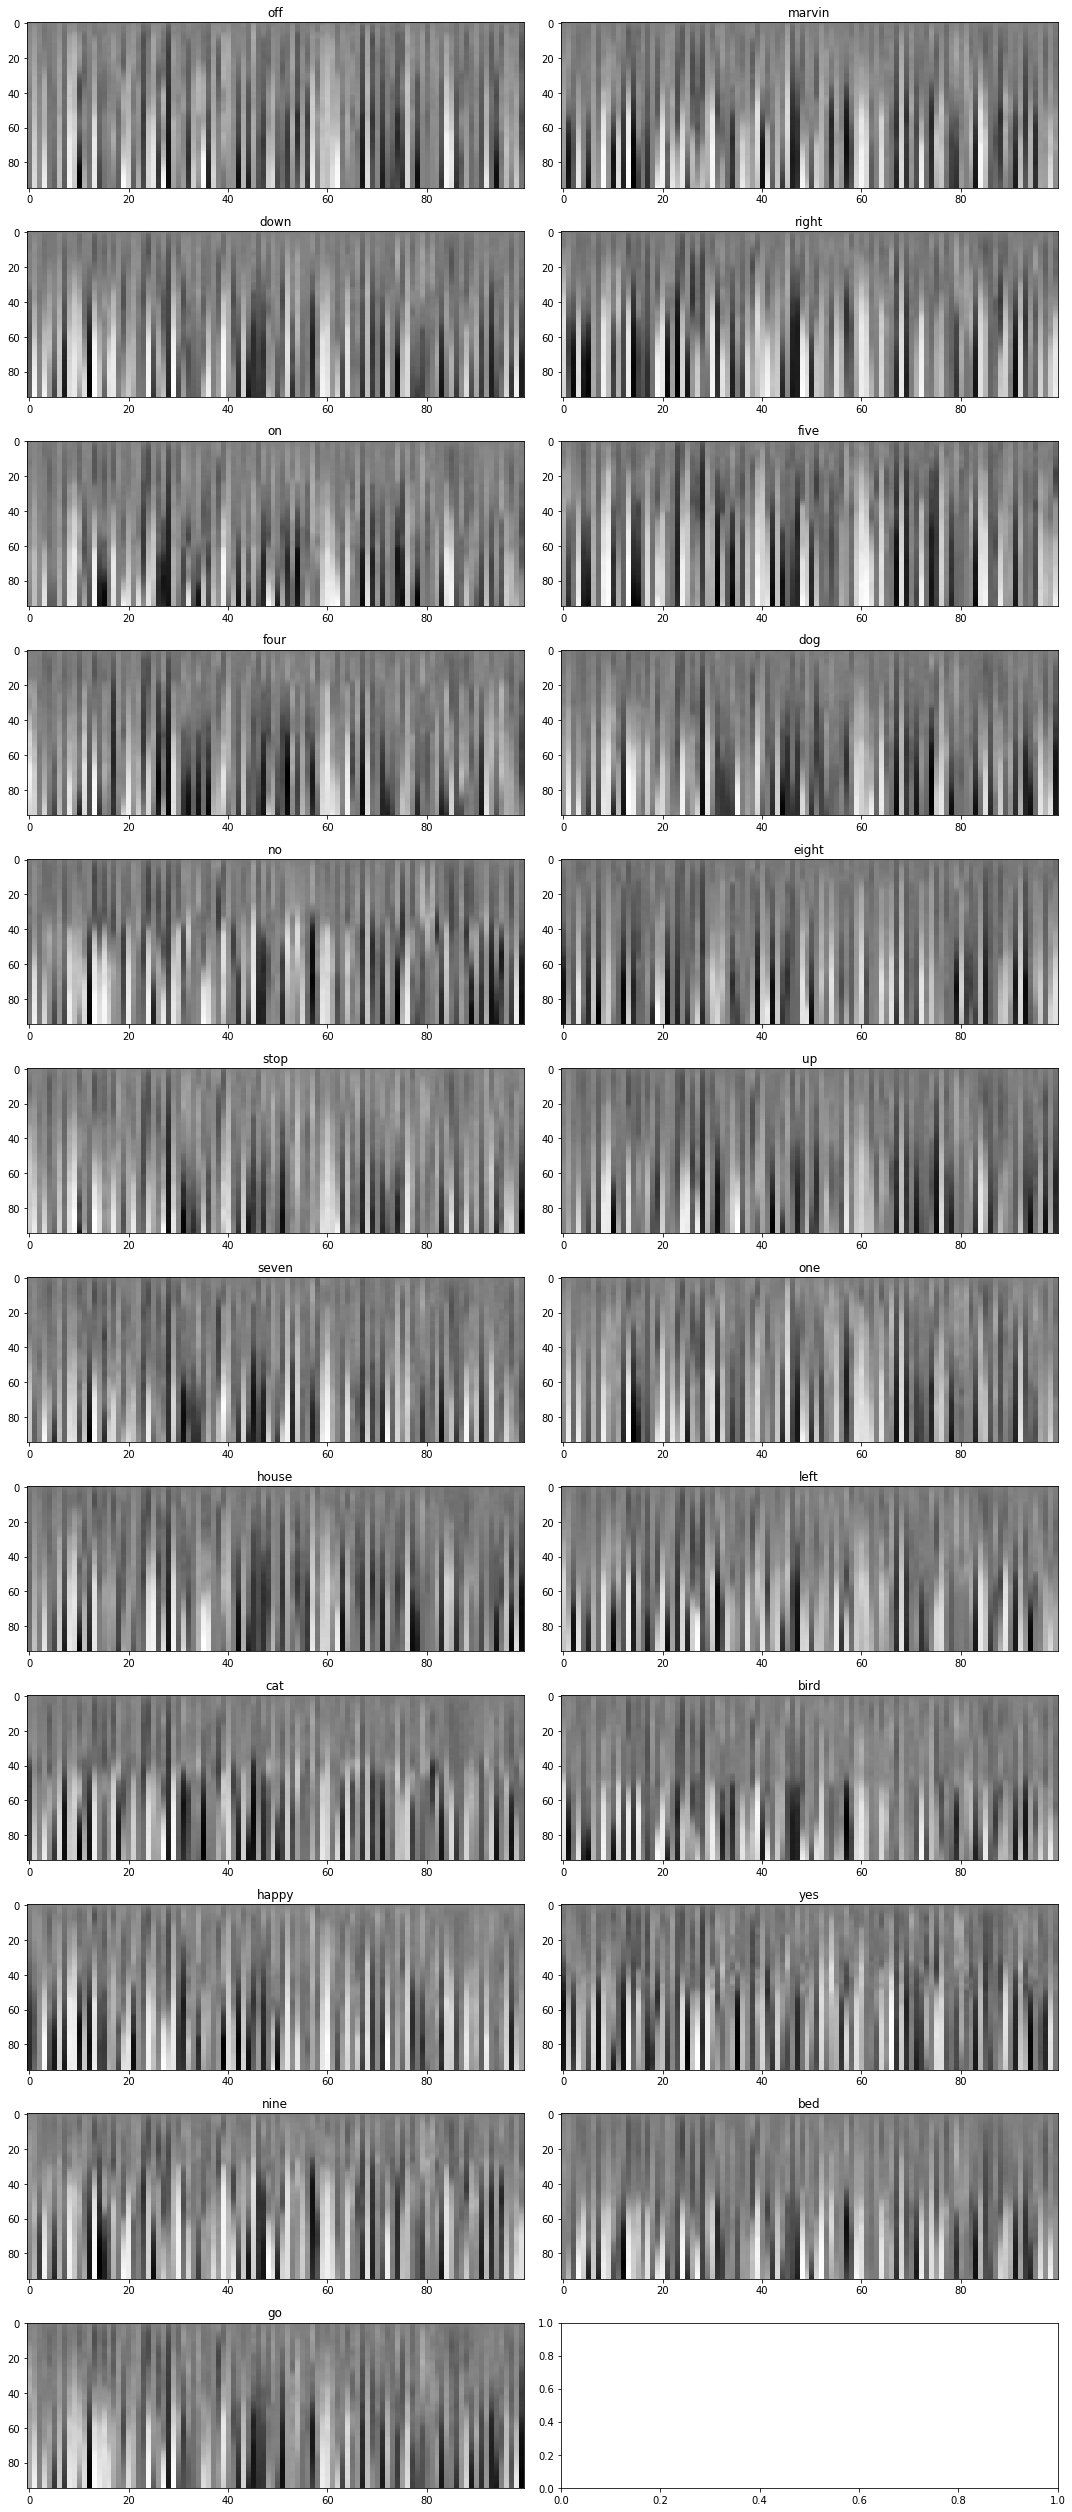

In [25]:
num_time_steps = train_x.shape[-1] // model_settings['hidden_reccurent_cells_count']

samples_dict = {}
for i in range(num_train_samples):
    sample_y = train_y[i]
    sample = np.reshape(train_x[i], (num_time_steps, -1))
    if sample_y not in samples_dict:
        samples_dict[sample_y] = []
    samples_dict[sample_y].append(sample)


len_keys = len(samples_dict.keys())
num_cols = 2
print(len_keys)
f, axarr = plt.subplots(nrows = len_keys // num_cols + 1, ncols = num_cols, figsize=(15,35))
i = 0

for k, v in samples_dict.items():
    avg_sample = np.mean(v, axis=0)
    axarr[i // num_cols, i % num_cols].imshow(avg_sample, cmap='gray', aspect='auto')
    axarr[i // num_cols, i % num_cols].set_title(k)
    i = i + 1
plt.tight_layout()
plt.show()

## 5 - Check the deltas of the hidden state dynamics

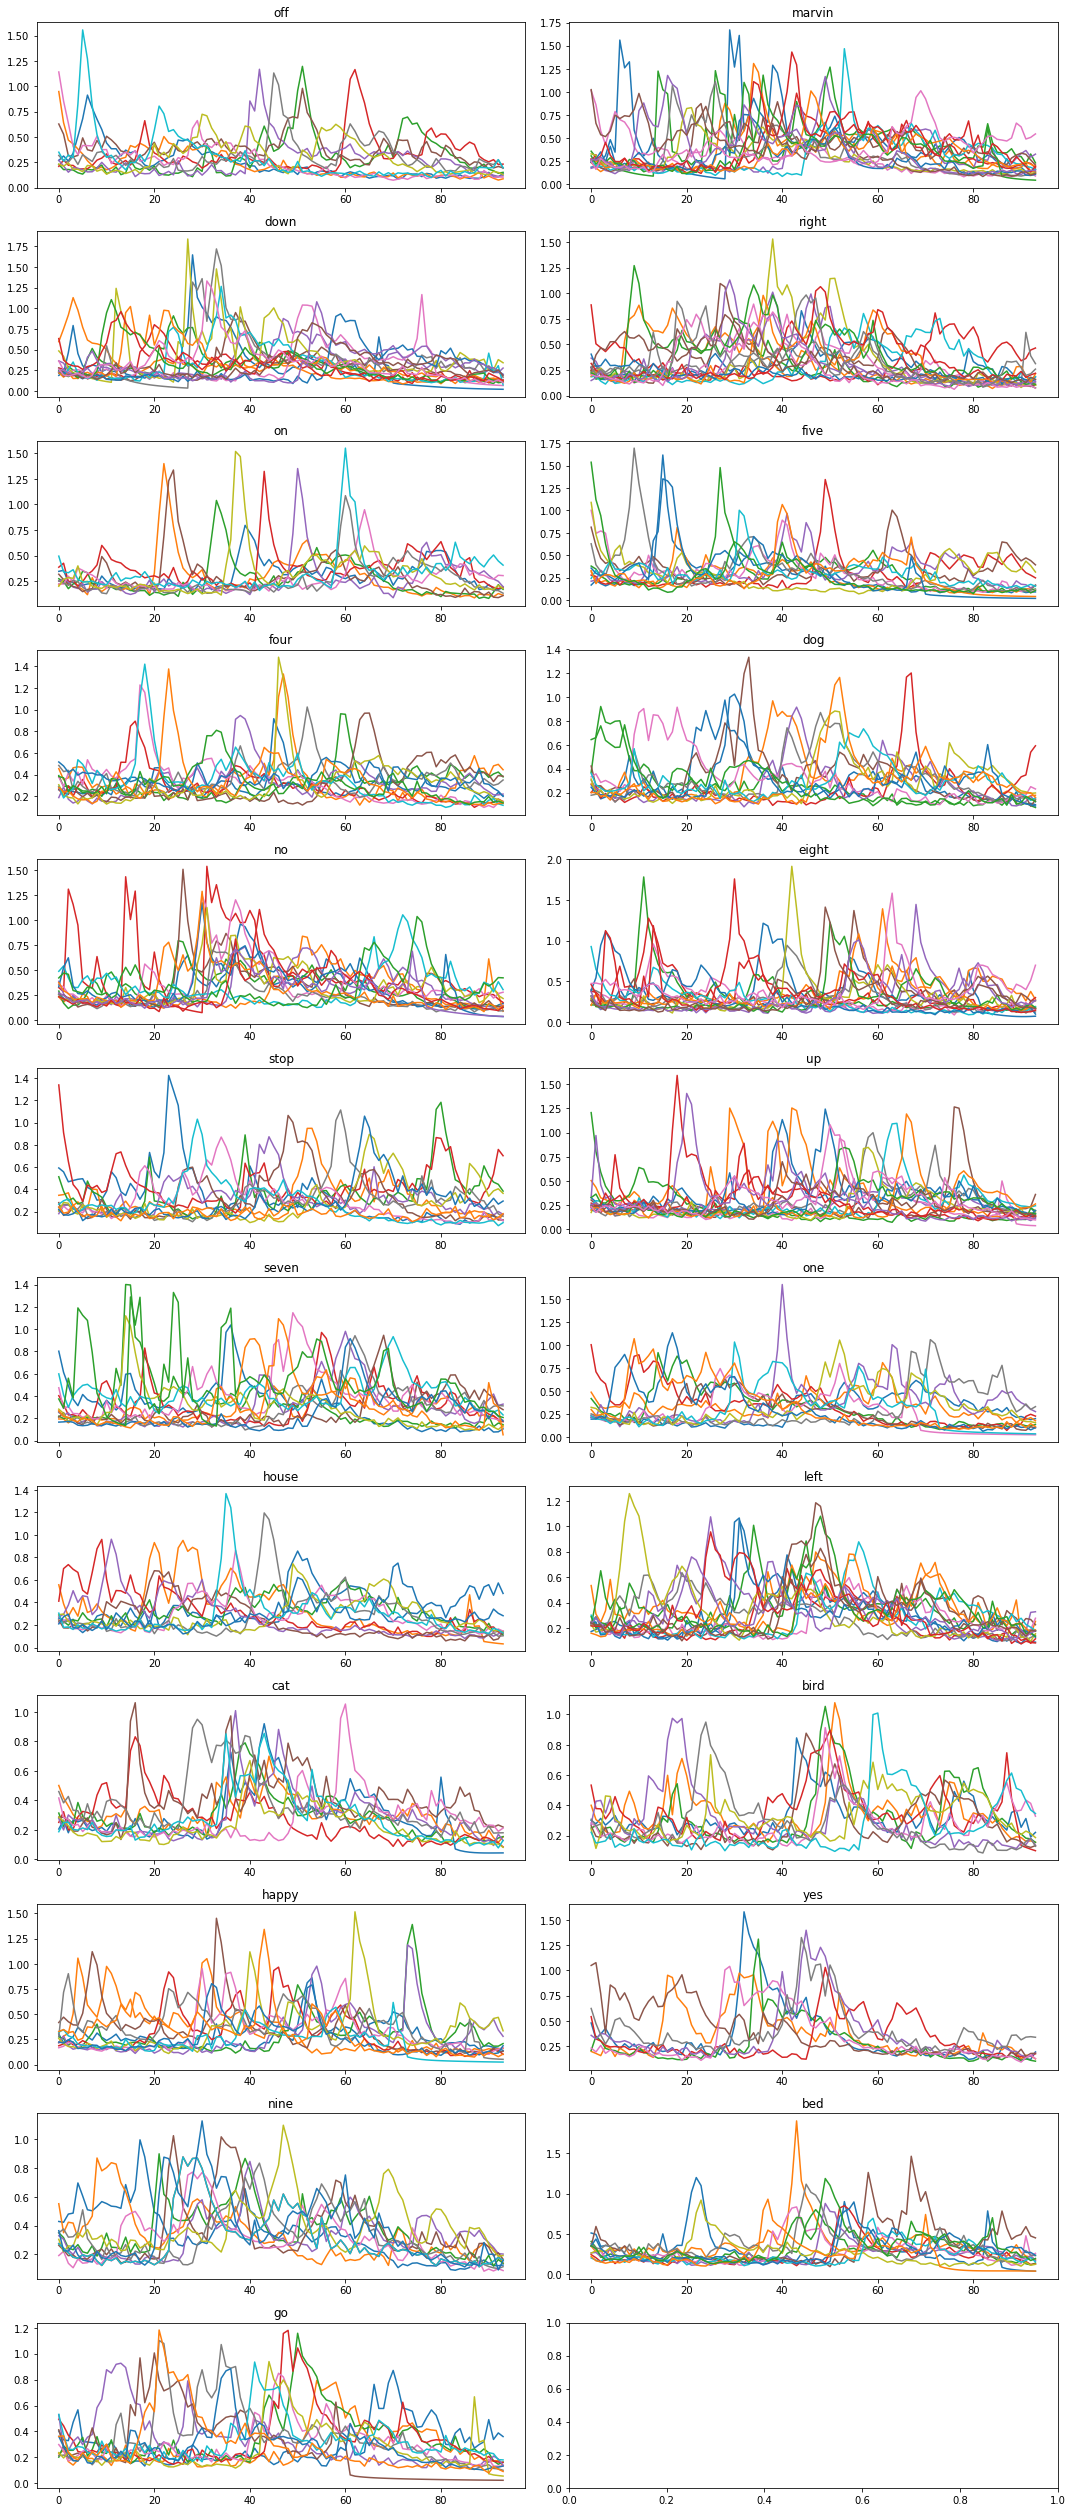

In [26]:
num_time_steps = train_x.shape[-1] // model_settings['hidden_reccurent_cells_count']
deltas_norm_dict = {}
deltas_norm = np.zeros((num_train_samples, num_time_steps-1))
for i in range(num_train_samples):
    sample_y = train_y[i]
    sample = np.reshape(train_x[i], (num_time_steps, -1))
    deltas = [sample[t] - sample[t-1] for t in range(1, num_time_steps)]
    deltas_norm[i] = np.linalg.norm(deltas, axis=1)
    if sample_y not in deltas_norm_dict:
        deltas_norm_dict[sample_y] = []
    deltas_norm_dict[sample_y].append(deltas_norm[i])

len_keys = len(deltas_norm_dict.keys())
f, axarr = plt.subplots(nrows = len_keys // num_cols + 1, ncols = num_cols, figsize=(15,35))
i = 0
for k, v in deltas_norm_dict.items():
    for j in range(len(v)):
        axarr[i // num_cols, i % num_cols].plot(v[j])
        axarr[i // num_cols, i % num_cols].set_title(k)
    i = i + 1
plt.tight_layout()
plt.show()

## 6 - Correlation between dynamics of the hidden states examplewise within one class

10 godpyn

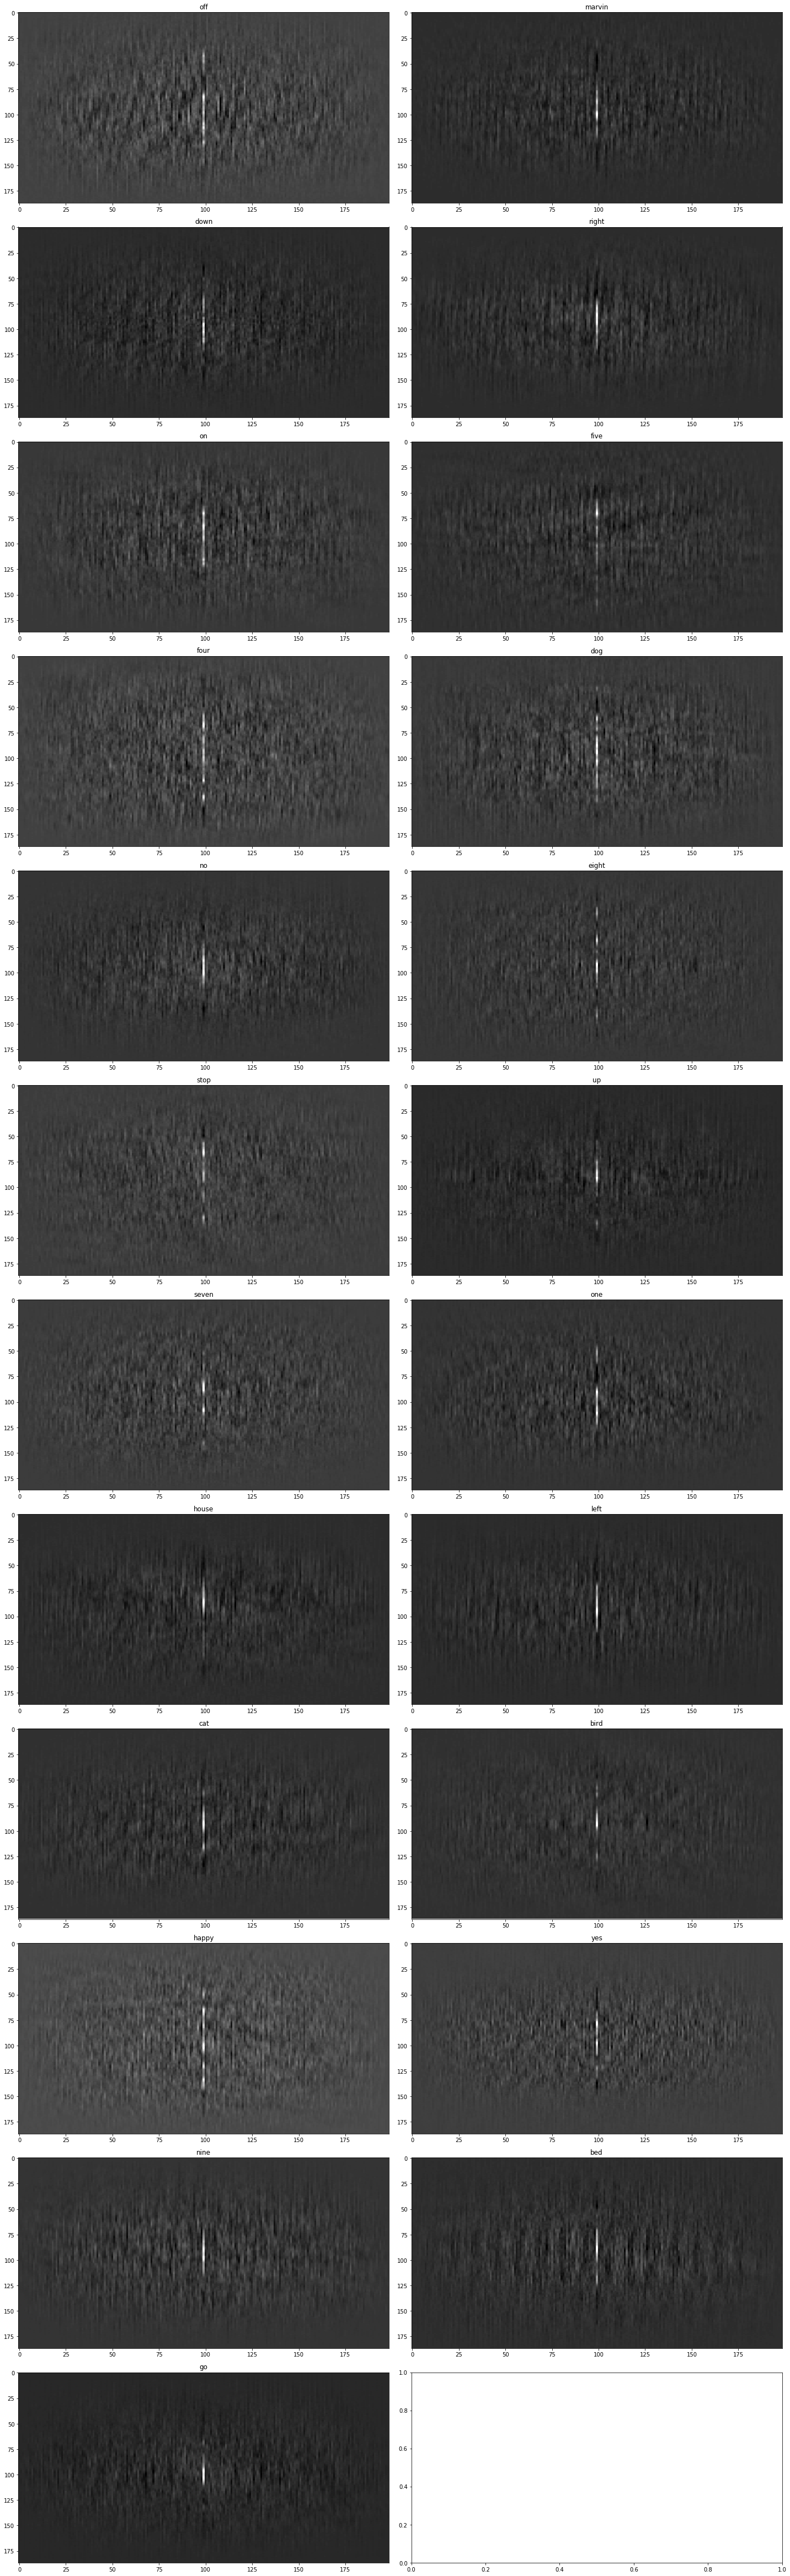

In [34]:
num_time_steps = train_x.shape[-1] // model_settings['hidden_reccurent_cells_count']
deltas_dict = {}
for i in range(num_train_samples):
    sample_y = train_y[i]
    sample = np.reshape(train_x[i], (num_time_steps, -1))
    deltas = [sample[t] - sample[t-1] for t in range(1, num_time_steps)]
    if sample_y not in deltas_dict:
        deltas_dict[sample_y] = []
    deltas_dict[sample_y].append(deltas)

len_keys = len(deltas_dict.keys())
f, axarr = plt.subplots(nrows = len_keys // num_cols + 1, ncols = num_cols, figsize=(20,65))
i = 0
for k, v in deltas_dict.items():
    corrs = []
    for j in range(len(v) - 1):
        print('\r' + str(j) + " " + k, end='')
        corr = signal.correlate(v[j], v[j + 1], mode='full')
        corrs.append(corr)
    corrs = np.array(corrs)
    corr_avg = np.mean(corrs, axis=0)
    axarr[i // num_cols, i % num_cols].imshow(corr_avg, cmap='gray', aspect="auto")
    axarr[i // num_cols, i % num_cols].set_title(k)
    i = i + 1
plt.tight_layout()
plt.show()

## 7 - Correlation between hidden states examplewise within one class

10 godpyn

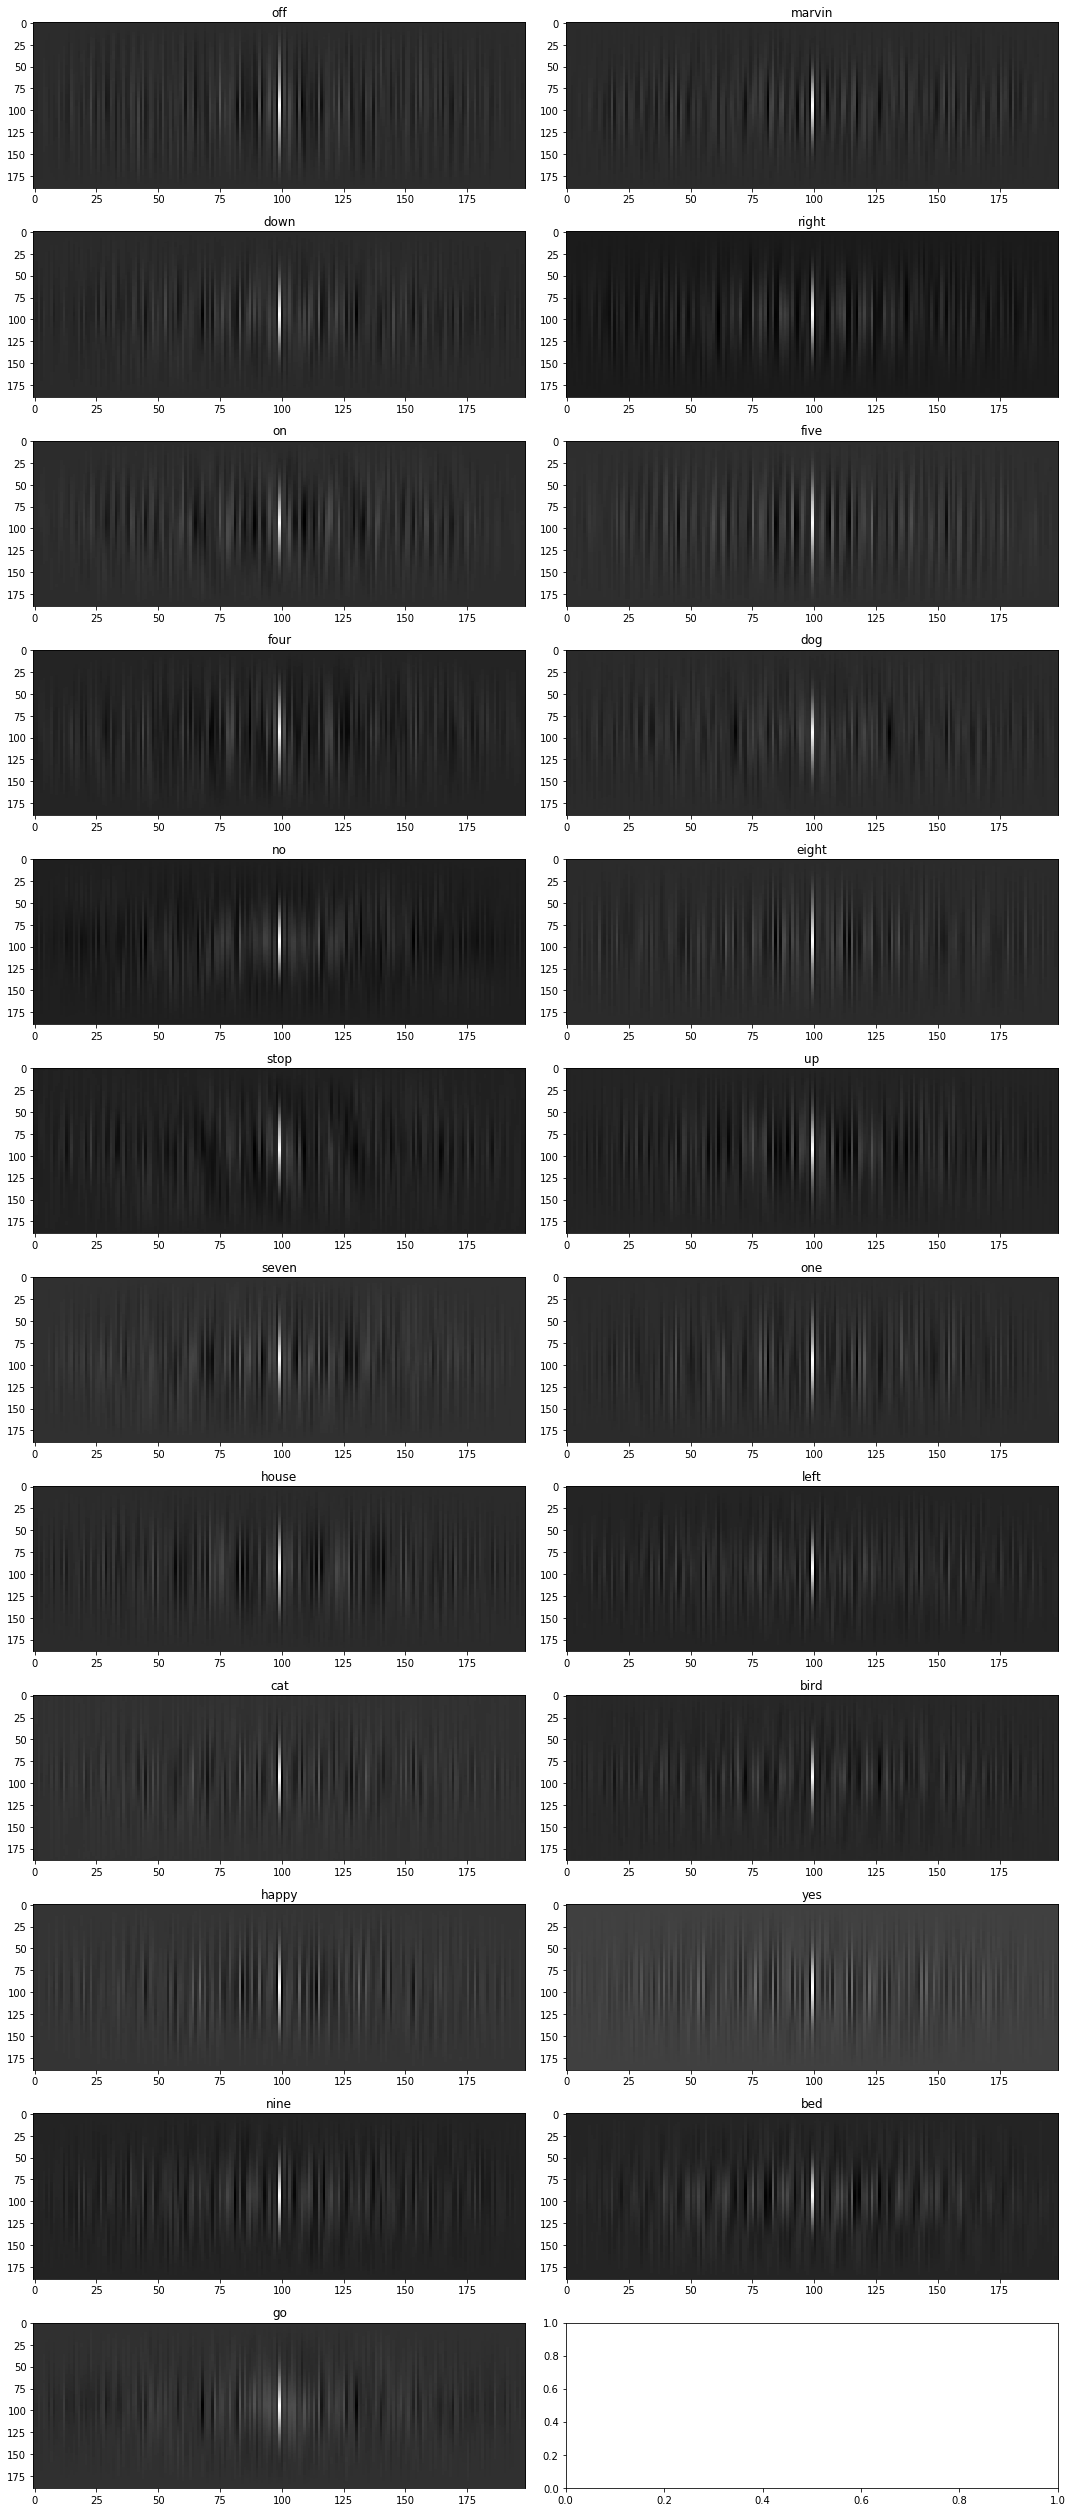

In [29]:
num_time_steps = train_x.shape[-1] // model_settings['hidden_reccurent_cells_count']
samples_dict = {}
for i in range(num_train_samples):
    sample_y = train_y[i]
    sample = np.reshape(train_x[i], (num_time_steps, -1))
    if sample_y not in samples_dict:
        samples_dict[sample_y] = []
    samples_dict[sample_y].append(sample)

len_keys = len(samples_dict.keys())
f, axarr = plt.subplots(nrows = len_keys // num_cols + 1, ncols = num_cols, figsize=(15,35))
i = 0
for k, v in samples_dict.items():
    corrs = []
    for j in range(len(v) - 1):
        print('\r' + str(j) + " " + k, end='')
        corr = signal.correlate(v[j], v[j + 1], mode='full')
        corrs.append(corr)
    corrs = np.array(corrs)
    corr_avg = np.mean(corrs, axis=0)
    axarr[i // num_cols, i % num_cols].imshow(corr_avg, cmap='gray', aspect="auto")
    axarr[i // num_cols, i % num_cols].set_title(k)
    i = i + 1
plt.tight_layout()
plt.show()

## 8 - Correlation between hidden states dynamics examplewise within one class

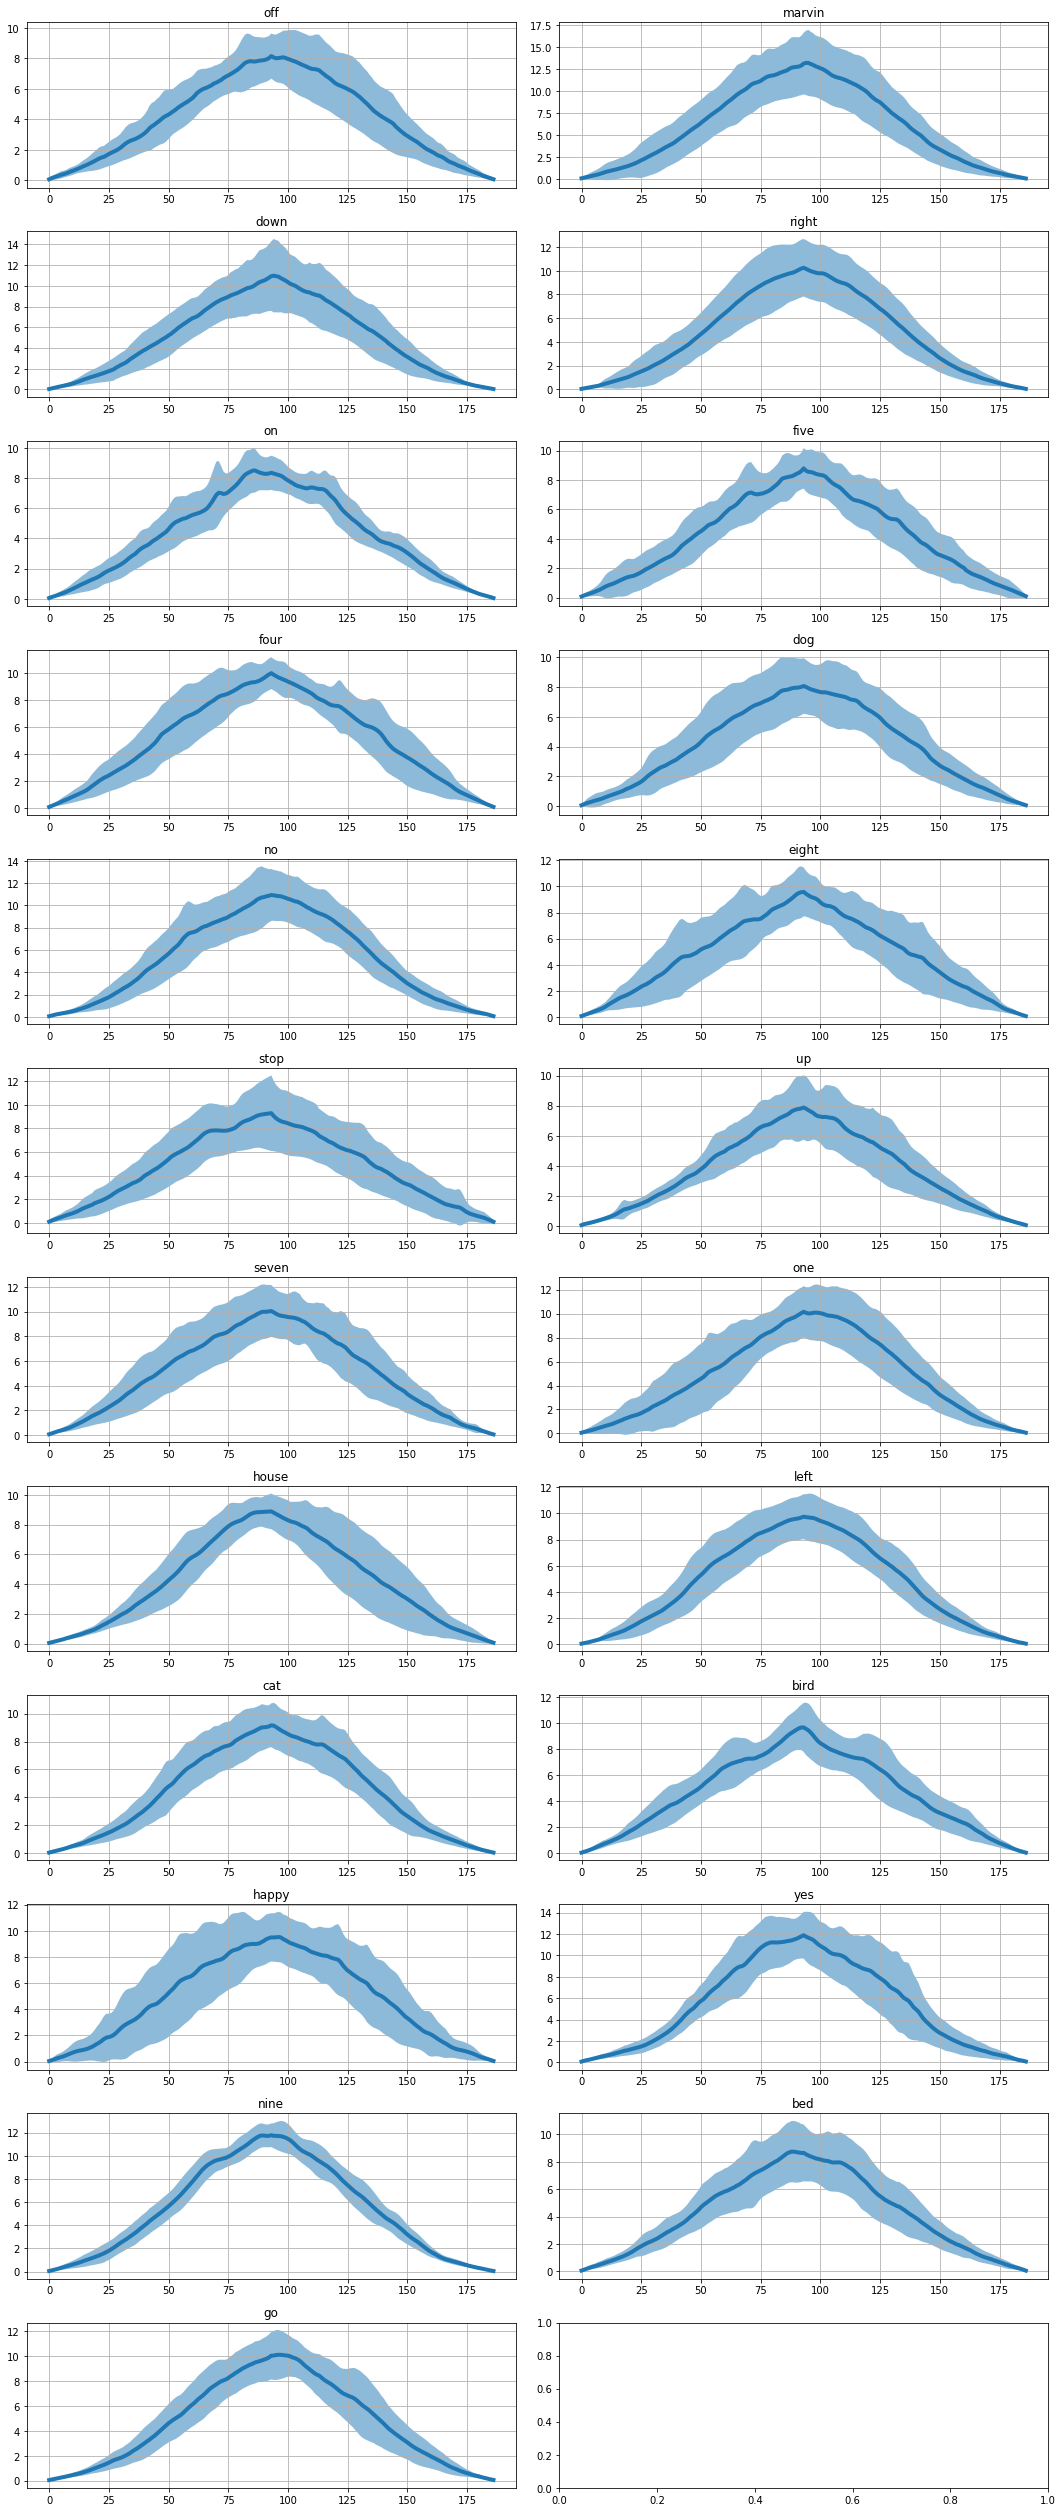

In [30]:
num_time_steps = train_x.shape[-1] // model_settings['hidden_reccurent_cells_count']
samples_dict = {}
deltas_norm_dict = {}
deltas_norm = np.zeros((num_train_samples, num_time_steps-1))
for i in range(num_train_samples):
    sample_y = train_y[i]
    sample = np.reshape(train_x[i], (num_time_steps, -1))
    if sample_y not in samples_dict:
        samples_dict[sample_y] = []
    samples_dict[sample_y].append(sample)
    deltas = [sample[t] - sample[t-1] for t in range(1, num_time_steps)]
    deltas_norm[i] = np.linalg.norm(deltas, axis=1)
    if sample_y not in deltas_norm_dict:
        deltas_norm_dict[sample_y] = []
    deltas_norm_dict[sample_y].append(deltas_norm[i])

len_keys = len(deltas_norm_dict.keys())
f, axarr = plt.subplots(nrows = len_keys // num_cols + 1, ncols = num_cols, figsize=(15,35))
i = 0
for k, v in deltas_norm_dict.items():
    corrs = []
    for j in range(len(v) - 1):
        corr = signal.correlate(v[j], v[j+1], mode='full')
        corrs.append(corr)
        
#         axarr[i].plot(corr)
    corrs = np.array(corrs)
    corr_avg = np.mean(corrs, axis=0)
    std = np.std(corrs, axis=0)
    x = np.arange(0, len(corr_avg), 1)
    axarr[i // num_cols, i % num_cols].plot(x, corr_avg, lw=4)
    axarr[i // num_cols, i % num_cols].fill_between(x, corr_avg + std, corr_avg-std, alpha=0.5)
    axarr[i // num_cols, i % num_cols].grid()
    axarr[i // num_cols, i % num_cols].set_title(k)
    i = i + 1
plt.tight_layout()
plt.show()